In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import permutations, combinations
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats
import pickle
import os
from scipy.spatial.distance import euclidean
import editdistance
from scipy.stats import pearsonr, wasserstein_distance
from scipy.spatial.distance import  euclidean
from scipy.stats import pearsonr, wasserstein_distance

DEVICE = "cpu" # set to GPU if available

In [2]:
class Sender(nn.Module):

    def __init__(self, num_concepts, hidden_size, device, num_layers=1, 
                 vocab_size=5, max_len=10, top_p=0.9, dropout_p=0, 
                 decoding_strategy="gumbel_softmax"):
        super().__init__()

        self.encoder = nn.Linear(num_concepts, hidden_size)
        self.grus = nn.ModuleList([nn.GRUCell(input_size=hidden_size, hidden_size=hidden_size) for _ in range(num_layers)])
        self.output = nn.Linear(hidden_size, vocab_size) # applied at every time step
        self.vocab_encoder = nn.Linear(vocab_size, hidden_size, bias=False)
        self.dropout = nn.Dropout(p=dropout_p)
        
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.max_len = max_len
        self.top_p = top_p
        self.decoding_strategy = decoding_strategy
        assert self.decoding_strategy in ["top_p", "sampling", "greedy", "gumbel_softmax"]
    
    def top_p_sampling(self, output):
        sorted_probabilities, sorted_indices = torch.sort(output, descending=True)
        cumulative_probabilities = torch.cumsum(sorted_probabilities, dim=0)
        top_p_mask = cumulative_probabilities <= self.top_p
        top_p_probabilities = sorted_probabilities[top_p_mask]
        top_p_indices = sorted_indices[top_p_mask]
        if len(top_p_probabilities) == 0: # If top_p is too low, fall back to greedy decoding
            next_token = torch.argmax(output) 
        else:
            next_token = top_p_indices[torch.multinomial(top_p_probabilities, 1).item()]
        return next_token

    def forward(self, x, eval=False, temperature=1.0):
        h_0 = self.encoder(x)
        latest_token = torch.zeros(self.hidden_size).to(self.device) # Not the same as token 0, it is an embedding state of all zeros
        # latest_token = torch.randn(self.hidden_size).to(self.device) 

        hidden_states = [h_0.clone() for _ in range(self.num_layers)]

        output_states = torch.zeros((self.max_len, self.vocab_size)).to(self.device)
        decoded_outputs = []

        for i in range(self.max_len-1):

            hidden_states[0] = self.grus[0](latest_token, hidden_states[0])
            for j in range(1, self.num_layers):
                x = self.grus[j](hidden_states[j-1], hidden_states[j])
                hidden_states[j] = x

            if not eval:
                logits = self.output(self.dropout(hidden_states[self.num_layers-1]))
                if self.decoding_strategy=="gumbel_softmax":
                    gumbel_logits = -torch.log(-torch.log(torch.rand_like(logits))) # sample from Gumbel(0, 1)
                    logits = (logits+gumbel_logits)/temperature
            else:
                logits = self.output(hidden_states[self.num_layers-1])
            
            # GRADIENT FLOW THROUGH GUMBEL SAMPLING and STRAIGHT THROUGH ESTIMATOR
            
            output = torch.softmax(logits, dim = 0)
            
            if self.decoding_strategy == "greedy":
                decoded = torch.argmax(output)
            elif self.decoding_strategy=="sampling":
                decoded = torch.multinomial(output, num_samples=1, replacement=True)[0]
            elif self.decoding_strategy=="top_p":
                decoded = self.top_p_sampling(output)
            elif self.decoding_strategy=="gumbel_softmax":
                decoded = torch.argmax(output)
                output_hard = torch.zeros_like(output)
                output_hard[decoded] = 1.0
                output = output_hard + output - output.detach() # Straight-through estimator removes content, keeps gradient

            output_states[i] = output
            decoded_outputs.append(decoded.item())
            
            if decoded.item() == 0: # EOS token detected
                break

            latest_token = self.vocab_encoder(output)
        
        decoded_outputs = decoded_outputs + [0]*(self.max_len-len(decoded_outputs)) # 0 = END TOKEN
        assert len(decoded_outputs) == self.max_len
    
        return output_states, decoded_outputs
    
class Receiver(nn.Module):
    def __init__ (self, num_concepts, hidden_size, device, num_layers=1, vocab_size=5, max_len=10):
        super().__init__()
        self.gru_embedding = nn.Linear(vocab_size, hidden_size, bias=False) # nn.Embedding(vocab_size, hidden_size)
        self.grus = nn.ModuleList([nn.GRUCell(input_size=hidden_size, hidden_size=hidden_size)])
        self.grus.extend([nn.GRUCell(input_size=hidden_size, hidden_size=hidden_size) for _ in range(1, num_layers)])
        self.output = nn.Linear(hidden_size, num_concepts)
        
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.max_len = max_len
    
    def forward(self, sender_outputs, decoded_output):

        hidden_states = [torch.zeros(self.hidden_size).to(self.device) for _ in range(self.num_layers)]
        for i in range(self.max_len):
            encoded_input = self.gru_embedding(sender_outputs[i])
            hidden_states[0] = self.grus[0](encoded_input, hidden_states[0]) # hidden_states[0] = self.grus[0](sender_outputs[i], hidden_states[0])
            for j in range(1, self.num_layers):
                hidden_states[j] = self.grus[j](hidden_states[j-1], hidden_states[j])
            if decoded_output[i] == 0:
                break
        output = self.output(hidden_states[self.num_layers-1])
        output = torch.softmax(output, dim=0)
        return output

class Agent:
    def __init__ (self, num_concepts, hidden_size, device, num_layers, vocab_size, max_len):
        self.sender = Sender(num_concepts, hidden_size, device, num_layers, vocab_size, max_len)
        self.receiver = Receiver(num_concepts, hidden_size, device, num_layers, vocab_size, max_len)

In [21]:
# HELPER FUNCTIONS

def transform(sentence):
    this_output = ""
    for ch in sentence:
        if ch==0:
            break
        this_output+=chr(ch+96)
    return this_output

def generate_ngrams(s, n):
    """Generate n-grams for a given string s."""
    return {s[i:i+n] for i in range(len(s) - n + 1)}

def sample_ngram_overlap(sample_decoded_outputs, n): # Generalisation of ROUGE-N, without a true "reference"
    n_grams = [generate_ngrams(sample_decoded_output, n) for sample_decoded_output in sample_decoded_outputs]
    intersection = set.intersection(*n_grams)
    union = set.union(*n_grams)
    if len(union)==0:
        return 0
    overlap_coefficient = len(intersection)/len(union) # Based on the formula for Jaccard Similarity
    return overlap_coefficient

def calculate_ngram_overlap(decoded_outputs, n):
    ngram_scores = []
    for sample_decoded_outputs in decoded_outputs:
        score = sample_ngram_overlap(sample_decoded_outputs, n=n)
        ngram_scores.append(score)
    return ngram_scores

def calculate_world_view(agents_dict):
    sender_cosine_matrix = []
    receiver_cosine_matrix = []

    for i, agent in enumerate(agents_dict):
        this_cosine_sim = cosine_similarity(agents_dict[agent].sender.vocab_encoder.weight.data.T, agents_dict[agent].sender.vocab_encoder.weight.data.T)
        this_cosine_sim = this_cosine_sim[np.tril_indices(this_cosine_sim.shape[0], k=-1)] # select lower triangular matrix
        sender_cosine_matrix.append(this_cosine_sim)  
    sender_cosine_matrix = np.array(sender_cosine_matrix)

    for i, agent in enumerate(agents_dict):
        this_cosine_sim = cosine_similarity(agents_dict[agent].receiver.gru_embedding.weight.data.T, agents_dict[agent].receiver.gru_embedding.weight.data.T)
        this_cosine_sim = this_cosine_sim[np.tril_indices(this_cosine_sim.shape[0], k=-1)]
        receiver_cosine_matrix.append(this_cosine_sim)
    receiver_cosine_matrix = np.array(receiver_cosine_matrix)

    ss_correlations, rr_correlations, sr_correlations = [], [], []
    for a0, a1 in combinations(range(len(agents_dict)), 2):
        this_ss_corr = stats.pearsonr(sender_cosine_matrix[a0], sender_cosine_matrix[a1])[0]
        this_rr_corr = stats.pearsonr(receiver_cosine_matrix[a0], receiver_cosine_matrix[a1])[0]
        ss_correlations.append(this_ss_corr)
        rr_correlations.append(this_rr_corr)
    
    for a0 in range(len(agents_dict)):
        this_sr_corr = stats.pearsonr(sender_cosine_matrix[a0], receiver_cosine_matrix[a0])[0]
        sr_correlations.append(this_sr_corr)

    return ss_correlations, rr_correlations, sr_correlations

def forward_pass_simple(agent0, agent1, x, temperature, loss_fn, returnData=False):

    sender0_outputs, sender0_decoded_output = agent0.sender(x, temperature=temperature)
    receiver1_outputs = agent1.receiver(sender0_outputs, sender0_decoded_output)

    loss = loss_fn(receiver1_outputs, x) # STAGE 1

    if returnData:
        return loss, sender0_decoded_output, receiver1_outputs
    else:
        return loss
    
def eval_pass_simple(agent0, agent1, x, temperature, loss_fn, returnData=False):
    with torch.no_grad():
        sender0_outputs, sender0_decoded_output = agent0.sender(x, temperature=temperature, eval=True)
        receiver1_outputs = agent1.receiver(sender0_outputs, sender0_decoded_output)
        loss0 = loss_fn(receiver1_outputs, x) 

    if returnData:
        return loss0, sender0_decoded_output, receiver1_outputs
    else:
        return loss0
    
def forward_pass_IC(agent0, agent1, x, temperature, loss_fn, returnData=False):

    sender0_outputs, sender0_decoded_output = agent0.sender(x, temperature=temperature)
    receiver1_outputs = agent0.receiver(sender0_outputs, sender0_decoded_output)

    loss = loss_fn(receiver1_outputs, x) # STAGE 1

    sender1_outputs, sender1_decoded_output = agent0.sender(receiver1_outputs, temperature=temperature)
    receiver2_outputs = agent1.receiver(sender1_outputs, sender1_decoded_output)

    loss += loss_fn(receiver2_outputs, receiver1_outputs) # STAGE 2

    if returnData:
        return loss, sender0_decoded_output, receiver1_outputs, sender1_decoded_output, receiver2_outputs
    else:
        return loss
    
def eval_pass_IC(agent0, agent1, x, temperature, loss_fn, returnData=False, returnExtra=False):
    with torch.no_grad():
        sender0_outputs, sender0_decoded_output = agent0.sender(x, temperature=temperature, eval=True)
        receiver1_outputs = agent0.receiver(sender0_outputs, sender0_decoded_output)
        loss0 = loss_fn(receiver1_outputs, x) # STAGE 1

        sender1_outputs, sender1_decoded_output = agent0.sender(receiver1_outputs, temperature=temperature, eval=True)
        receiver2_outputs = agent1.receiver(sender1_outputs, sender1_decoded_output)
        loss1 = loss_fn(receiver2_outputs, x) # STAGE 1 

        lossEndToEnd = loss_fn(receiver2_outputs, x) # END-TO-END

    if returnData:
        if returnExtra:
            return loss0, loss1, lossEndToEnd, sender0_decoded_output, receiver1_outputs, sender1_decoded_output, receiver2_outputs
        else:
            return lossEndToEnd, sender1_decoded_output, receiver2_outputs
    else:
        return lossEndToEnd

def topological_similarity(o, m, distance="euclidean"):
    assert distance in ["euclidean", "wasserstein"]

    d_o = []
    for i in range(len(o)):
        for j in range(i+1, len(o)):
            if distance=="euclidean":
                d_o.append(euclidean(o[i], o[j]))
            elif distance=="wasserstein":
                d_o.append(wasserstein_distance(o[i], o[j]))
    d_o = np.array(d_o)

    d_m = []
    for i in range(len(m)):
        for j in range(i+1, len(m)):
            d_m.append(editdistance.eval(m[i], m[j]))
    d_m = np.array(d_m)

    return pearsonr(d_o, d_m)

def calculate_topological_similarity(agents_dict, dataset, decoded_outputs, directional=False, distance="euclidean"):
    top_sim_values = []
    o = dataset.dataset.tensors[0]
    if not directional:
        for i in range(0, len(list(permutations(agents_dict))), len(agents_dict)-1):
            m = decoded_outputs[:, i]
            top_sim = topological_similarity(o, m, distance)[0]
            top_sim_values.append(top_sim)
    else:
        for i in range(0, len(agents_dict)):
            m = decoded_outputs[:, i]
            top_sim = topological_similarity(o, m, distance)[0]
            top_sim_values.append(top_sim)
    return np.mean(top_sim_values)

def calculate_edit_distances(decoded_outputs, numAgents=True):
    edit_distances = []

    if numAgents==2:
        for i in range(len(decoded_outputs)):
            this_sample = editdistance.distance(decoded_outputs[i][0], decoded_outputs[i][1])/max(len(decoded_outputs[i][0]), len(decoded_outputs[i][1]), 1)
            edit_distances.append(this_sample)
    else:
        decoded_outputs = decoded_outputs[:, ::2]
        for i in range(len(decoded_outputs)):
            # print (decoded_outputs[i][0], decoded_outputs[i][1], decoded_outputs[i][2])
            this_sample = 0
            this_sample += editdistance.distance(decoded_outputs[i][0], decoded_outputs[i][1])/max(len(decoded_outputs[i][0]), len(decoded_outputs[i][1]), 1)
            this_sample += editdistance.distance(decoded_outputs[i][0], decoded_outputs[i][2])/max(len(decoded_outputs[i][0]), len(decoded_outputs[i][2]), 1)
            this_sample += editdistance.distance(decoded_outputs[i][1], decoded_outputs[i][2])/max(len(decoded_outputs[i][1]), len(decoded_outputs[i][2]), 1)
            this_sample /= 3
            edit_distances.append(this_sample)

    return np.mean(edit_distances)

def evaluate_matches(decoded_outputs, val_results, agents_dict):

    ngram_scores_1 = calculate_ngram_overlap(decoded_outputs, n=1)
    val_results["1-gram_mean"].append(np.mean(ngram_scores_1))

    ngram_scores_2 = calculate_ngram_overlap(decoded_outputs, n=2)
    val_results["2-gram_mean"].append(np.mean(ngram_scores_2))

    ngram_scores_3 = calculate_ngram_overlap(decoded_outputs, n=3)
    val_results["3-gram_mean"].append(np.mean(ngram_scores_3))

    ngram_scores_4 = calculate_ngram_overlap(decoded_outputs, n=4)
    val_results["4-gram_mean"].append(np.mean(ngram_scores_4))

    ss_correlations, rr_correlations, sr_correlations = calculate_world_view(agents_dict)
    val_results["ss_correlations_mean"].append(np.mean(ss_correlations))
    val_results["rr_correlations_mean"].append(np.mean(rr_correlations))
    val_results["sr_correlations_mean"].append(np.mean(sr_correlations))

    edit_distance = calculate_edit_distances(decoded_outputs, numAgents=len(agents_dict))
    val_results["edit_distance_mean"].append(edit_distance)

    return val_results

def get_agent_pair_fc(agents_dict, competitive_level):
    pairs = list(permutations(agents_dict.keys(), 2))
    multiplicative_factors = [np.random.choice([-1,1], p=[competitive_level, 1-competitive_level]) for _ in range(len(pairs))]
    return zip(pairs, multiplicative_factors)

def get_agent_pair_ring(agents_dict, competitive_level):
    pairs = []
    for i in range(3):
        pairs.append((i, (i+1)%3))
    multiplicative_factors = [np.random.choice([-1,1], p=[competitive_level, 1-competitive_level]) for _ in range(len(pairs))]
    return zip(pairs, multiplicative_factors)

In [22]:
# Main training function, with support for competitiveness, inner speech, and various topologies

def simulate_with_competitiveness(
                                agents_dict, 
                                train_dataset, 
                                val_dataset, 
                                lr=0.001, 
                                epochs=300, 
                                batch_size=16, 
                                temp_start=1, 
                                temp_end=1, 
                                verbose=False, 
                                evalEpochs=5, 
                                competitive_level=0,
                                fn_generate_pair=get_agent_pair_fc,
                                fn_forward_pass=forward_pass_simple,
                                fn_eval_pass=eval_pass_simple,
                                directional=False,
                                loss_fn=nn.MSELoss()):

    opts = {f"sender_{k}": torch.optim.Adam(v.sender.parameters(), lr=lr) for k, v in agents_dict.items()}
    opts.update({f"receiver_{k}": torch.optim.Adam(v.receiver.parameters(), lr=lr) for k, v in agents_dict.items()})

    epoch_losses = [] # Training loss
    agents_val_lossEnfToEnd = {combo : [] for combo in permutations(agents_dict.keys(), 2)}
    val_results = {
        "self_intelligibility_mean": [],
        "ss_correlations_mean": [],
        "rr_correlations_mean": [],
        "sr_correlations_mean": [],
        "1-gram_mean": [], # same as Jaccard Similarity
        "2-gram_mean": [],
        "3-gram_mean": [],
        "4-gram_mean": [],
        "topological_similarity_mean": [],
        "edit_distance_mean": []
    }

    for epoch in range(epochs):
        epoch_loss = 0
        num_samples = 0

        for opt in opts.values():
            opt.zero_grad()
        loss = 0

        temperature = max(temp_end, temp_start + (temp_end - temp_start) * (epoch / epochs))

        for j, x in enumerate(train_dataset.dataset.tensors[0]):
            
            for (agent0, agent1), mult_factor in fn_generate_pair(agents_dict, competitive_level):
                loss += mult_factor*fn_forward_pass(agents_dict[agent0], agents_dict[agent1], x, temperature, loss_fn)
            
            if j%batch_size == 0:
                loss.backward()
                for opt in opts.values():
                    opt.step()
                    opt.zero_grad()
                epoch_loss += loss
                loss = 0

            num_samples += 1 # len(x)

        epoch_loss /= num_samples
        epoch_losses.append(epoch_loss.item())
        
        if epoch % evalEpochs == 0 or epoch == epochs-1:
            
            if verbose:
                print (f"Epoch {epoch+1}")
                print (f"Training loss: {epoch_loss.item()}")

            this_epoch_val_loss = defaultdict(float)
            this_epoch_decoded_output = []
            self_play_loss = []

            for x in val_dataset.dataset.tensors[0]:
                this_sample_decoded_output = []
                
                for name0, name1 in permutations(agents_dict.keys(), 2):
                    _loss, _senderOutput, _ = fn_eval_pass(agents_dict[name0], agents_dict[name1], x, temperature, loss_fn, returnData=True)
                    this_epoch_val_loss[(name0, name1)] += _loss.item()
                    this_sample_decoded_output.append(transform(_senderOutput))
                
                for agent_name in agents_dict.keys():
                    self_play_loss.append(fn_eval_pass(agents_dict[agent_name], agents_dict[agent_name], x, temperature, loss_fn).item())

                this_epoch_decoded_output.append(this_sample_decoded_output)

            this_epoch_decoded_output = np.array(this_epoch_decoded_output)
            # this_epoch_decoded_output = this_epoch_decoded_output[:, ::2]
            
            val_results = evaluate_matches(this_epoch_decoded_output, val_results, agents_dict)
            val_results["self_intelligibility_mean"].append(np.mean(self_play_loss))
            val_results["topological_similarity_mean"].append(calculate_topological_similarity(agents_dict, val_dataset, this_epoch_decoded_output, directional=directional))
            
            for name0, name1 in permutations(agents_dict.keys(), 2):
                agents_val_lossEnfToEnd[(name0, name1)].append(this_epoch_val_loss[(name0, name1)]/len(val_dataset))
                if verbose:
                    print (f"Validation loss ({name0} -> {name1}): {agents_val_lossEnfToEnd[(name0, name1)][-1]}")
        
            print ("="*50)
    
    return epoch_losses, agents_val_lossEnfToEnd, val_results

<Axes: >

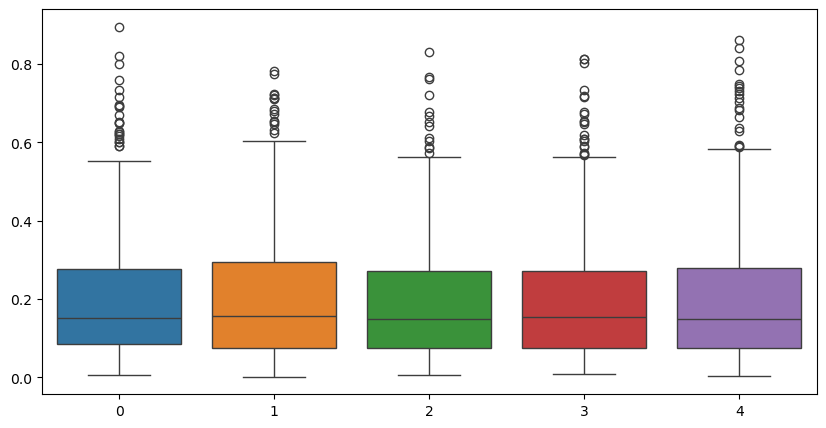

In [23]:
# DATA GENERATION

NUM_CONCEPTS_DIMS = 5
NUM_SAMPLES = NUM_CONCEPTS_DIMS*100
BATCH_SIZE = 32

torch.manual_seed(42)
sender_targets = torch.softmax(torch.randn(size = (NUM_SAMPLES, NUM_CONCEPTS_DIMS), device=DEVICE), dim = 1)

# DATA SPLIT
dataset = torch.utils.data.TensorDataset(sender_targets)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(data=sender_targets, ax=ax)

# Experiment 8.1 - 3 Fully Connected Agents, without Inner Speech

In [38]:
NUM_RUNS = 3

HIDDEN_SIZE = 32
NUM_LAYERS = 1
VOCAB_SIZE = 9
MAX_LEN = 5

runs_epoch_losses = []
runs_agents_val_lossEnfToEnd = []
runs_val_results = []

for i in range(NUM_RUNS): 
    agents_dict = {
        0: Agent(NUM_CONCEPTS_DIMS, HIDDEN_SIZE, DEVICE, NUM_LAYERS, VOCAB_SIZE, MAX_LEN),
        1: Agent(NUM_CONCEPTS_DIMS, HIDDEN_SIZE, DEVICE, NUM_LAYERS, VOCAB_SIZE, MAX_LEN),
        2: Agent(NUM_CONCEPTS_DIMS, HIDDEN_SIZE, DEVICE, NUM_LAYERS, VOCAB_SIZE, MAX_LEN)
    }
    epoch_losses, agents_val_lossEnfToEnd, val_results = simulate_with_competitiveness(
        agents_dict, 
        train_dataset,
        val_dataset,
        epochs=500, 
        batch_size=16, 
        verbose=True, 
        evalEpochs=10,
        competitive_level=0.0
    )
    runs_epoch_losses.append(epoch_losses)
    runs_agents_val_lossEnfToEnd.append(agents_val_lossEnfToEnd)
    runs_val_results.append(val_results)

Epoch 1
Training loss: 0.1588231474161148
Validation loss (0 -> 1): 0.26245445032021963
Validation loss (0 -> 2): 0.2623244161484763
Validation loss (1 -> 0): 0.2633183699019719
Validation loss (1 -> 2): 0.263270394387655
Validation loss (2 -> 0): 0.266228602809133
Validation loss (2 -> 1): 0.26266267815139144
Epoch 11
Training loss: 0.08886328339576721
Validation loss (0 -> 1): 0.13204291996284157
Validation loss (0 -> 2): 0.13024628087470774
Validation loss (1 -> 0): 0.1439338110340759
Validation loss (1 -> 2): 0.13234286548249657
Validation loss (2 -> 0): 0.1199506537624984
Validation loss (2 -> 1): 0.11607153980439762
Epoch 21
Training loss: 0.047385793179273605
Validation loss (0 -> 1): 0.0765847966549336
Validation loss (0 -> 2): 0.07744879558857065
Validation loss (1 -> 0): 0.06404348074807785
Validation loss (1 -> 2): 0.06749949677614495
Validation loss (2 -> 0): 0.05858804844727274
Validation loss (2 -> 1): 0.05830523604643531
Epoch 31
Training loss: 0.031482722610235214
Valid

/Users/adithyavh/anaconda3/envs/rl/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Validation loss (0 -> 1): 0.2634468774078414
Validation loss (0 -> 2): 0.2635426861804444
Validation loss (1 -> 0): 0.263212647291366
Validation loss (1 -> 2): 0.26338837916147895
Validation loss (2 -> 0): 0.26338818251620977
Validation loss (2 -> 1): 0.26387681761174464
Epoch 11
Training loss: 0.10413450002670288
Validation loss (0 -> 1): 0.1736723079548392
Validation loss (0 -> 2): 0.17707168538094264
Validation loss (1 -> 0): 0.1318183813279029
Validation loss (1 -> 2): 0.13167854657236602
Validation loss (2 -> 0): 0.17749348910961998
Validation loss (2 -> 1): 0.17649417801119852
Epoch 21
Training loss: 0.07575362175703049
Validation loss (0 -> 1): 0.13137482465012
Validation loss (0 -> 2): 0.1300869041099213
Validation loss (1 -> 0): 0.08311122474027798
Validation loss (1 -> 2): 0.08200588357110973
Validation loss (2 -> 0): 0.13701117531076307
Validation loss (2 -> 1): 0.13194475535303354
Epoch 31
Training loss: 0.05055463686585426
Validation loss (0 -> 1): 0.09408469423469797
Vali

/Users/adithyavh/anaconda3/envs/rl/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Validation loss (0 -> 1): 0.26326457770890554
Validation loss (0 -> 2): 0.2632461903197691
Validation loss (1 -> 0): 0.26363124448456804
Validation loss (1 -> 2): 0.2638290307694115
Validation loss (2 -> 0): 0.2639074913912918
Validation loss (2 -> 1): 0.264008609278244
Epoch 11
Training loss: 0.07014760375022888
Validation loss (0 -> 1): 0.08467038386384956
Validation loss (0 -> 2): 0.08613383604417323
Validation loss (1 -> 0): 0.10815577321365709
Validation loss (1 -> 2): 0.10610217504989122
Validation loss (2 -> 0): 0.11790003432543017
Validation loss (2 -> 1): 0.11221621821285226
Epoch 21
Training loss: 0.04169260337948799
Validation loss (0 -> 1): 0.053481649156310596
Validation loss (0 -> 2): 0.05300749162037391
Validation loss (1 -> 0): 0.06444675844919402
Validation loss (1 -> 2): 0.06116906884242781
Validation loss (2 -> 0): 0.05752496463159332
Validation loss (2 -> 1): 0.05490230973227881
Epoch 31
Training loss: 0.030619382858276367
Validation loss (0 -> 1): 0.041165624399000

In [63]:
# AGGREGRATE RESULTS FROM MULTIPLE RUNS

agg_val_results = {}
std_val_results = {}

for key in runs_val_results[0].keys():
    agg_val_results[key] = np.mean([np.nan_to_num(run[key]) for run in runs_val_results], axis=0)
    std_val_results[key] = np.std([np.nan_to_num(run[key]) for run in runs_val_results], axis=0)

agg_epoch_losses = np.array(runs_epoch_losses).mean(axis=0)
std_epoch_losses = np.array(runs_epoch_losses).std(axis=0)

agg_agents_val_lossEnfToEnd = {combo : [] for combo in permutations(agents_dict.keys(), 2)}
std_agents_val_lossEnfToEnd = {combo : [] for combo in permutations(agents_dict.keys(), 2)}

for val_loss in runs_agents_val_lossEnfToEnd:
    for key, val in val_loss.items():
        agg_agents_val_lossEnfToEnd[key].append(val)

for key in agg_agents_val_lossEnfToEnd:
    std_agents_val_lossEnfToEnd[key] = np.std(agg_agents_val_lossEnfToEnd[key], axis=0)
    agg_agents_val_lossEnfToEnd[key] = np.mean(agg_agents_val_lossEnfToEnd[key], axis=0)

In [12]:
"""
LOADING: Uncomment below and load previous results from file if needed
"""
pass

# NUM_RUNS = 3

# HIDDEN_SIZE = 32
# NUM_LAYERS = 1
# VOCAB_SIZE = 9
# MAX_LEN = 5

# EXPT_NAME = "exp8.1"

# with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "rb") as f:
#     agg_epoch_losses = pickle.load(f)

# with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "rb") as f:
#     std_epoch_losses = pickle.load(f)

# with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "rb") as f:
#     agg_agents_val_lossEnfToEnd = pickle.load(f)

# with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "rb") as f:
#     std_agents_val_lossEnfToEnd = pickle.load(f)

# with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "rb") as f:
#     agg_val_results = pickle.load(f)

# with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "rb") as f:
#     std_val_results = pickle.load(f)

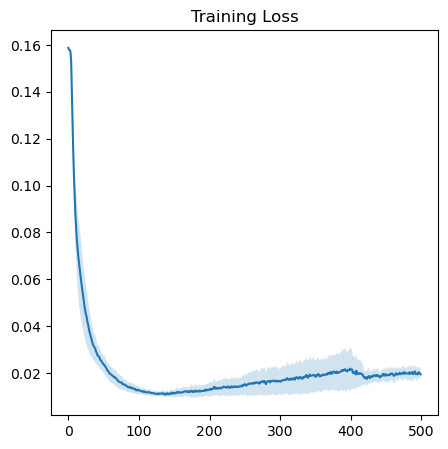

In [14]:
epoch_gap = 10
epochs = 500 + epoch_gap
epoch_line_period = 100

f, ax = plt.subplots(1, 1, figsize=(5, 5))

# training loss
ax.set_title("Training Loss")
ax.plot(agg_epoch_losses)
ax.fill_between(np.arange(0, epochs-epoch_gap, 1),
                        agg_epoch_losses - std_epoch_losses, 
                        agg_epoch_losses + std_epoch_losses, 
                        alpha=0.2)


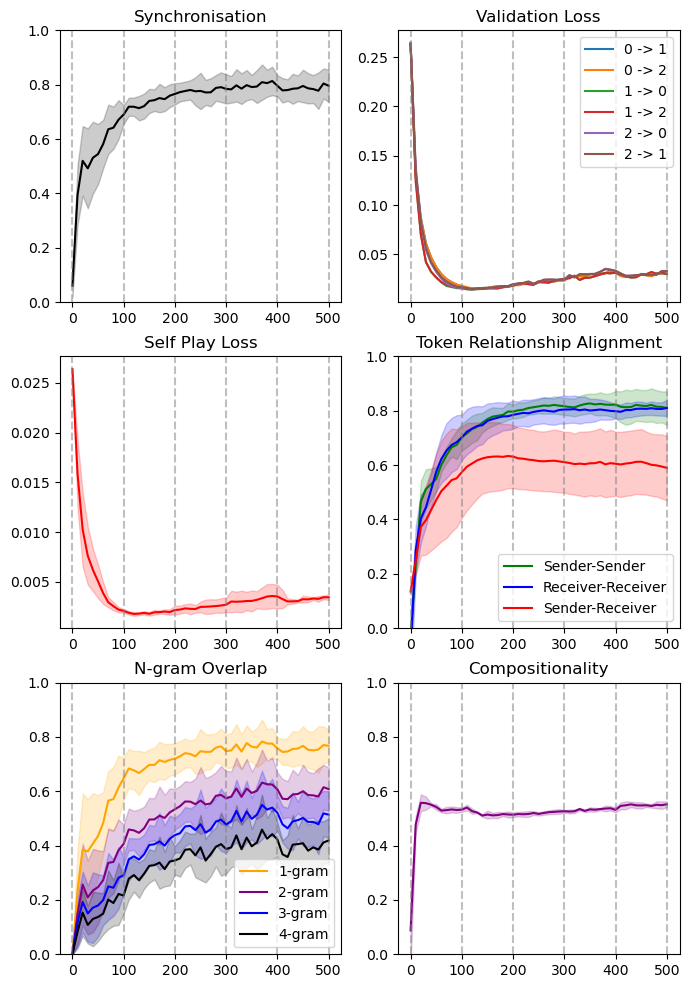

In [16]:
f, ax = plt.subplots(3, 2, figsize=(8, 12))

ax[0, 0].set_title("Synchronisation")
ax[0, 0].plot(np.arange(0, epochs, epoch_gap), 1-agg_val_results["edit_distance_mean"], label="Edit Distance", color = "black")
ax[0, 0].fill_between(np.arange(0, epochs, epoch_gap),
                        1-agg_val_results["edit_distance_mean"] - std_val_results["edit_distance_mean"], 
                        1-agg_val_results["edit_distance_mean"] + std_val_results["edit_distance_mean"], 
                        alpha=0.2, color = "black")
ax[0, 0].set_ylim(0,1)

# validation loss
for i, (k, v) in enumerate(agg_agents_val_lossEnfToEnd.items()):
    ax[0, 1].plot(np.arange(0, epochs, epoch_gap), v, label=f"{k[0]} -> {k[1]}")
ax[0, 1].legend()
ax[0, 1].set_title("Validation Loss")

ax[1, 0].set_title("Self Play Loss")
ax[1, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["self_intelligibility_mean"], label="Self Play Loss", color = "red")
ax[1, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["self_intelligibility_mean"] - std_val_results["self_intelligibility_mean"], 
                      agg_val_results["self_intelligibility_mean"] + std_val_results["self_intelligibility_mean"], 
                      alpha=0.2, color = "red")

ax[1, 1].set_title("Token Relationship Alignment")
ax[1, 1].plot(np.arange(0, epochs, epoch_gap), agg_val_results["ss_correlations_mean"], label="Sender-Sender", color = 'green')
ax[1, 1].plot(np.arange(0, epochs, epoch_gap), agg_val_results["rr_correlations_mean"], label="Receiver-Receiver", color = 'blue')
ax[1, 1].plot(np.arange(0, epochs, epoch_gap), agg_val_results["sr_correlations_mean"], label="Sender-Receiver", color = 'red')
ax[1, 1].legend()
ax[1, 1].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["ss_correlations_mean"] - std_val_results["ss_correlations_mean"], 
                      agg_val_results["ss_correlations_mean"] + std_val_results["ss_correlations_mean"], 
                      alpha=0.2, color = 'green')
ax[1, 1].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["rr_correlations_mean"] - std_val_results["rr_correlations_mean"], 
                      agg_val_results["rr_correlations_mean"] + std_val_results["rr_correlations_mean"], 
                      alpha=0.2, color = 'blue')
ax[1, 1].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["sr_correlations_mean"] - std_val_results["sr_correlations_mean"], 
                      agg_val_results["sr_correlations_mean"] + std_val_results["sr_correlations_mean"], 
                      alpha=0.2, color = 'red')
ax[1, 1].set_ylim(0, 1)

ax[2, 0].set_title("N-gram Overlap")
ax[2, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["1-gram_mean"], label="1-gram", color = 'orange')
ax[2, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                        agg_val_results["1-gram_mean"] - std_val_results["1-gram_mean"], 
                        agg_val_results["1-gram_mean"] + std_val_results["1-gram_mean"], 
                        alpha=0.2, color = 'orange')

ax[2, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["2-gram_mean"], label="2-gram", color = 'purple')
ax[2, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["2-gram_mean"] - std_val_results["2-gram_mean"], 
                      agg_val_results["2-gram_mean"] + std_val_results["2-gram_mean"], 
                      alpha=0.2, color = 'purple')

ax[2, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["3-gram_mean"], label="3-gram", color = 'blue')
ax[2, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["3-gram_mean"] - std_val_results["3-gram_mean"], 
                      agg_val_results["3-gram_mean"] + std_val_results["3-gram_mean"], 
                      alpha=0.2, color = 'blue')

ax[2, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["4-gram_mean"], label="4-gram", color = 'black')
ax[2, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["4-gram_mean"] - std_val_results["4-gram_mean"], 
                      agg_val_results["4-gram_mean"] + std_val_results["4-gram_mean"], 
                      alpha=0.2, color = 'black')
ax[2, 0].set_ylim(0, 1)
ax[2, 0].legend()

ax[2, 1].set_title("Compositionality")
ax[2, 1].plot(np.arange(0, epochs, epoch_gap), agg_val_results["topological_similarity_mean"], label="Topological Similarity", color = "purple")
ax[2, 1].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["topological_similarity_mean"] - std_val_results["topological_similarity_mean"], 
                      agg_val_results["topological_similarity_mean"] + std_val_results["topological_similarity_mean"], 
                      alpha=0.2, color = "purple")
ax[2, 1].set_ylim(0, 1)


for i in range(0, epochs, epoch_line_period):
    for j in range(3):
        ax[j, 0].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        ax[j, 1].axvline(x=i, color='gray', linestyle='--', alpha=0.5)


plt.show()


In [24]:
"""
SAVING: Uncomment below and save current model and results to file if needed
"""
pass

# EXPT_NAME = "exp8.1"

# os.makedirs(f"./ModelFiles/{EXPT_NAME}", exist_ok=True)

# for agent in agents_dict:
#     torch.save(agents_dict[agent].sender.state_dict(), f"./ModelFiles/{EXPT_NAME}/sender_{agent}.pth")
#     torch.save(agents_dict[agent].receiver.state_dict(), f"./ModelFiles/{EXPT_NAME}/receiver_{agent}.pth")

# with open(f"./ModelFiles/{EXPT_NAME}/agg_epoch_losses.pkl", "wb") as f:
#     pickle.dump(agg_epoch_losses, f)

# with open(f"./ModelFiles/{EXPT_NAME}/std_epoch_losses.pkl", "wb") as f:
#     pickle.dump(std_epoch_losses, f)

# with open(f"./ModelFiles/{EXPT_NAME}/agg_val_results.pkl", "wb") as f:
#     pickle.dump(agg_val_results, f)

# with open(f"./ModelFiles/{EXPT_NAME}/std_val_results.pkl", "wb") as f:
#     pickle.dump(std_val_results, f)

# with open(f"./ModelFiles/{EXPT_NAME}/agg_agents_val_lossEnfToEnd.pkl", "wb") as f:
#     pickle.dump(agg_agents_val_lossEnfToEnd, f)    

# with open(f"./ModelFiles/{EXPT_NAME}/std_agents_val_lossEnfToEnd.pkl", "wb") as f:
#     pickle.dump(std_agents_val_lossEnfToEnd, f)

In [19]:
"""
LOADING: Uncomment below and load previous model if needed
"""
pass

EXPT_NAME = "exp8.1"

agents_dict = {
        0: Agent(NUM_CONCEPTS_DIMS, HIDDEN_SIZE, DEVICE, NUM_LAYERS, VOCAB_SIZE, MAX_LEN),
        1: Agent(NUM_CONCEPTS_DIMS, HIDDEN_SIZE, DEVICE, NUM_LAYERS, VOCAB_SIZE, MAX_LEN),
        2: Agent(NUM_CONCEPTS_DIMS, HIDDEN_SIZE, DEVICE, NUM_LAYERS, VOCAB_SIZE, MAX_LEN)
    }

for agent in agents_dict:
    # load
    agents_dict[agent].sender.load_state_dict(torch.load(f"./ModelFiles/{EXPT_NAME}/sender_{agent}.pth"))
    agents_dict[agent].receiver.load_state_dict(torch.load(f"./ModelFiles/{EXPT_NAME}/receiver_{agent}.pth"))

In [20]:
decoded_outputs = []
loss_fn = nn.MSELoss()

this_epoch_val_loss = defaultdict(float)

for i, x in enumerate(test_dataset.dataset.tensors[0]):
    this_sample_outputs = []
    for name0, name1 in permutations(agents_dict.keys(), 2):
        _loss, _senderOutput, _receiverOutput = eval_pass_simple(agents_dict[name0], agents_dict[name1], x, 1, loss_fn, returnData=True)
        this_epoch_val_loss[(name0, name1)] += _loss.item()
        if i<100:
            print(f"Agent{name0} {x.numpy().round(2)} -> {transform(_senderOutput)} -> Agent{name1} {_receiverOutput.numpy().round(2)}")
        this_sample_outputs.append(transform(_senderOutput))
    
    decoded_outputs.append(this_sample_outputs)
    if i<100:
        print ()

for name0, name1 in permutations(agents_dict.keys(), 2):
    this_epoch_val_loss[(name0, name1)] /= len(test_dataset)
    print (f"Validation loss ({name0} -> {name1}): {this_epoch_val_loss[(name0, name1)]}")

Agent0 [0.43 0.28 0.16 0.01 0.12] -> eeee -> Agent1 [0.51 0.13 0.11 0.13 0.12]
Agent0 [0.43 0.28 0.16 0.01 0.12] -> eeee -> Agent2 [0.51 0.15 0.11 0.12 0.11]
Agent1 [0.43 0.28 0.16 0.01 0.12] -> eeee -> Agent0 [0.5  0.14 0.11 0.12 0.11]
Agent1 [0.43 0.28 0.16 0.01 0.12] -> eeee -> Agent2 [0.51 0.15 0.11 0.12 0.11]
Agent2 [0.43 0.28 0.16 0.01 0.12] -> eeee -> Agent0 [0.5  0.14 0.11 0.12 0.11]
Agent2 [0.43 0.28 0.16 0.01 0.12] -> eeee -> Agent1 [0.51 0.13 0.11 0.13 0.12]

Agent0 [0.04 0.13 0.03 0.07 0.73] -> gggh -> Agent1 [0.06 0.14 0.06 0.06 0.69]
Agent0 [0.04 0.13 0.03 0.07 0.73] -> gggh -> Agent2 [0.06 0.11 0.06 0.06 0.71]
Agent1 [0.04 0.13 0.03 0.07 0.73] -> gggg -> Agent0 [0.05 0.11 0.05 0.04 0.75]
Agent1 [0.04 0.13 0.03 0.07 0.73] -> gggg -> Agent2 [0.04 0.08 0.05 0.04 0.78]
Agent2 [0.04 0.13 0.03 0.07 0.73] -> gggg -> Agent0 [0.05 0.11 0.05 0.04 0.75]
Agent2 [0.04 0.13 0.03 0.07 0.73] -> gggg -> Agent1 [0.05 0.11 0.05 0.05 0.75]

Agent0 [0.28 0.1  0.2  0.23 0.19] -> eeed -> Agent

# Running Other Experiments

In [ ]:
NUM_RUNS = 3 # CHANGE THIS TO 1 IF YOU WANT TO RUN ONLY ONCE

HIDDEN_SIZE = 32 # HIDDEN SIZE OF RNN
NUM_LAYERS = 1 # DO NOT CHANGE - UNSTABLE FOR >1
VOCAB_SIZE = 9 # VOCABULARY SIZE
MAX_LEN = 5 # MAXIMUM LENGTH OF OUTPUT SEQUENCE

runs_epoch_losses = []
runs_agents_val_lossEnfToEnd = []
runs_val_results = []

for i in range(NUM_RUNS): 

    #------------------------------------------#
    # TO USE 3 AGENTS
    agents_dict = {
        0: Agent(NUM_CONCEPTS_DIMS, HIDDEN_SIZE, DEVICE, NUM_LAYERS, VOCAB_SIZE, MAX_LEN),
        1: Agent(NUM_CONCEPTS_DIMS, HIDDEN_SIZE, DEVICE, NUM_LAYERS, VOCAB_SIZE, MAX_LEN),
        2: Agent(NUM_CONCEPTS_DIMS, HIDDEN_SIZE, DEVICE, NUM_LAYERS, VOCAB_SIZE, MAX_LEN)
    }

    #------------------------------------------#
    # TO USE ONLY A PAIR OF AGENTS

    # agents_dict = {
    #     0: Agent(NUM_CONCEPTS_DIMS, HIDDEN_SIZE, DEVICE, NUM_LAYERS, VOCAB_SIZE, MAX_LEN),
    #     1: Agent(NUM_CONCEPTS_DIMS, HIDDEN_SIZE, DEVICE, NUM_LAYERS, VOCAB_SIZE, MAX_LEN),
    # }

    #------------------------------------------#
    # OTHER EXPERIMENTS

    epoch_losses, agents_val_lossEnfToEnd, val_results = simulate_with_competitiveness(
        agents_dict, 
        train_dataset,
        val_dataset,
        epochs=500, 
        batch_size=16, 
        verbose=True, 
        evalEpochs=10,
        competitive_level=0.4,
        fn_generate_pair=get_agent_pair_fc, # OR get_agent_pair_ring (samples agent pairs)
        fn_forward_pass=forward_pass_simple, # OR forward_pass_IC (for inner speech)
        fn_eval_pass=eval_pass_simple, # OR eval_pass_IC (for inner speech)
    )

    runs_epoch_losses.append(epoch_losses)
    runs_agents_val_lossEnfToEnd.append(agents_val_lossEnfToEnd)
    runs_val_results.append(val_results)

In [ ]:
# AGGREGRATE RESULTS FROM MULTIPLE RUNS

agg_val_results = {}
std_val_results = {}

for key in runs_val_results[0].keys():
    agg_val_results[key] = np.mean([np.nan_to_num(run[key]) for run in runs_val_results], axis=0)
    std_val_results[key] = np.std([np.nan_to_num(run[key]) for run in runs_val_results], axis=0)

agg_epoch_losses = np.array(runs_epoch_losses).mean(axis=0)
std_epoch_losses = np.array(runs_epoch_losses).std(axis=0)

agg_agents_val_lossEnfToEnd = {combo : [] for combo in permutations(agents_dict.keys(), 2)}
std_agents_val_lossEnfToEnd = {combo : [] for combo in permutations(agents_dict.keys(), 2)}

for val_loss in runs_agents_val_lossEnfToEnd:
    for key, val in val_loss.items():
        agg_agents_val_lossEnfToEnd[key].append(val)

for key in agg_agents_val_lossEnfToEnd:
    std_agents_val_lossEnfToEnd[key] = np.std(agg_agents_val_lossEnfToEnd[key], axis=0)
    agg_agents_val_lossEnfToEnd[key] = np.mean(agg_agents_val_lossEnfToEnd[key], axis=0)

In [ ]:
f, ax = plt.subplots(3, 2, figsize=(8, 12))

ax[0, 0].set_title("Synchronisation")
ax[0, 0].plot(np.arange(0, epochs, epoch_gap), 1-agg_val_results["edit_distance_mean"], label="Edit Distance", color = "black")
ax[0, 0].fill_between(np.arange(0, epochs, epoch_gap),
                        1-agg_val_results["edit_distance_mean"] - std_val_results["edit_distance_mean"], 
                        1-agg_val_results["edit_distance_mean"] + std_val_results["edit_distance_mean"], 
                        alpha=0.2, color = "black")
ax[0, 0].set_ylim(0,1)

# validation loss
for i, (k, v) in enumerate(agg_agents_val_lossEnfToEnd.items()):
    ax[0, 1].plot(np.arange(0, epochs, epoch_gap), v, label=f"{k[0]} -> {k[1]}")
ax[0, 1].legend()
ax[0, 1].set_title("Validation Loss")

ax[1, 0].set_title("Self Play Loss")
ax[1, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["self_intelligibility_mean"], label="Self Play Loss", color = "red")
ax[1, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["self_intelligibility_mean"] - std_val_results["self_intelligibility_mean"], 
                      agg_val_results["self_intelligibility_mean"] + std_val_results["self_intelligibility_mean"], 
                      alpha=0.2, color = "red")

ax[1, 1].set_title("Token Relationship Alignment")
ax[1, 1].plot(np.arange(0, epochs, epoch_gap), agg_val_results["ss_correlations_mean"], label="Sender-Sender", color = 'green')
ax[1, 1].plot(np.arange(0, epochs, epoch_gap), agg_val_results["rr_correlations_mean"], label="Receiver-Receiver", color = 'blue')
ax[1, 1].plot(np.arange(0, epochs, epoch_gap), agg_val_results["sr_correlations_mean"], label="Sender-Receiver", color = 'red')
ax[1, 1].legend()
ax[1, 1].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["ss_correlations_mean"] - std_val_results["ss_correlations_mean"], 
                      agg_val_results["ss_correlations_mean"] + std_val_results["ss_correlations_mean"], 
                      alpha=0.2, color = 'green')
ax[1, 1].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["rr_correlations_mean"] - std_val_results["rr_correlations_mean"], 
                      agg_val_results["rr_correlations_mean"] + std_val_results["rr_correlations_mean"], 
                      alpha=0.2, color = 'blue')
ax[1, 1].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["sr_correlations_mean"] - std_val_results["sr_correlations_mean"], 
                      agg_val_results["sr_correlations_mean"] + std_val_results["sr_correlations_mean"], 
                      alpha=0.2, color = 'red')
ax[1, 1].set_ylim(0, 1)

ax[2, 0].set_title("N-gram Overlap")
ax[2, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["1-gram_mean"], label="1-gram", color = 'orange')
ax[2, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                        agg_val_results["1-gram_mean"] - std_val_results["1-gram_mean"], 
                        agg_val_results["1-gram_mean"] + std_val_results["1-gram_mean"], 
                        alpha=0.2, color = 'orange')

ax[2, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["2-gram_mean"], label="2-gram", color = 'purple')
ax[2, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["2-gram_mean"] - std_val_results["2-gram_mean"], 
                      agg_val_results["2-gram_mean"] + std_val_results["2-gram_mean"], 
                      alpha=0.2, color = 'purple')

ax[2, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["3-gram_mean"], label="3-gram", color = 'blue')
ax[2, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["3-gram_mean"] - std_val_results["3-gram_mean"], 
                      agg_val_results["3-gram_mean"] + std_val_results["3-gram_mean"], 
                      alpha=0.2, color = 'blue')

ax[2, 0].plot(np.arange(0, epochs, epoch_gap), agg_val_results["4-gram_mean"], label="4-gram", color = 'black')
ax[2, 0].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["4-gram_mean"] - std_val_results["4-gram_mean"], 
                      agg_val_results["4-gram_mean"] + std_val_results["4-gram_mean"], 
                      alpha=0.2, color = 'black')
ax[2, 0].set_ylim(0, 1)
ax[2, 0].legend()

ax[2, 1].set_title("Compositionality")
ax[2, 1].plot(np.arange(0, epochs, epoch_gap), agg_val_results["topological_similarity_mean"], label="Topological Similarity", color = "purple")
ax[2, 1].fill_between(np.arange(0, epochs, epoch_gap), 
                      agg_val_results["topological_similarity_mean"] - std_val_results["topological_similarity_mean"], 
                      agg_val_results["topological_similarity_mean"] + std_val_results["topological_similarity_mean"], 
                      alpha=0.2, color = "purple")
ax[2, 1].set_ylim(0, 1)


for i in range(0, epochs, epoch_line_period):
    for j in range(3):
        ax[j, 0].axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        ax[j, 1].axvline(x=i, color='gray', linestyle='--', alpha=0.5)


plt.show()